# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [32]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Setup matplotlib
plt.rcParams["figure.figsize"] = (15,10)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [13]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [14]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [15]:
#your turn
merged = df_transactions.merge(df_offers, on='offer_id')
merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [16]:
pivot = pd.pivot_table(merged, values='n', index='customer_name', columns='offer_id', fill_value=0)
pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### What values of 𝑆𝑆 do you believe represent better clusterings? Why?
* Good values of SS are those that are low, without having too large of a K value. You want to have tight clusters, without having a cluster for every data point. This is why you use the elbow method as a heuristic to find the right tradeoff between tight (self-similar) clusters and overfitting.

Text(0, 0.5, 'Sum-of-squares distance (Inertia)')

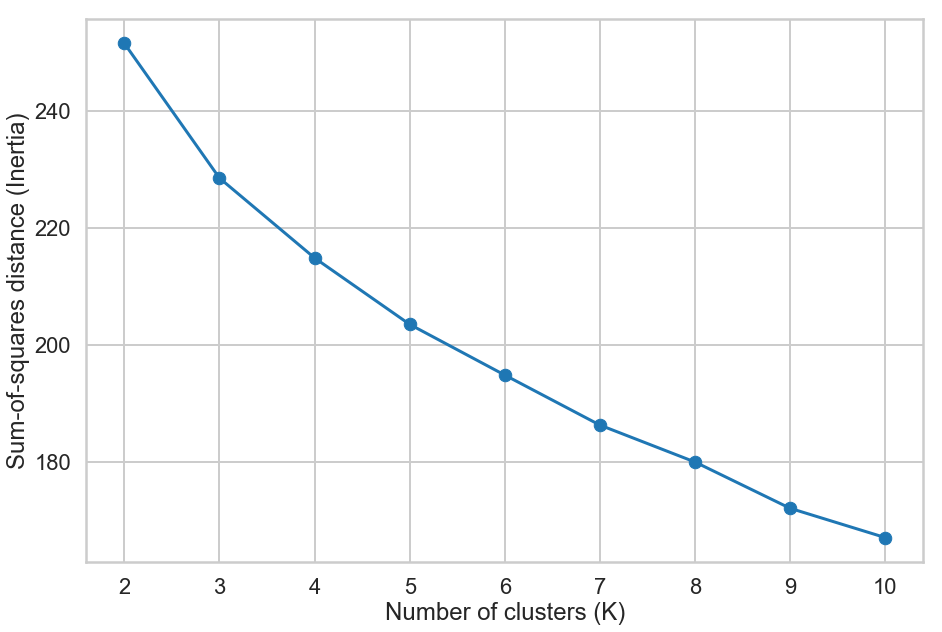

In [17]:
# your turn
from sklearn.cluster import KMeans

# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
x_cols = pivot.values

# Fit KMeans to x_cols for specified values of K
ks = range(2,11)
SS = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(x_cols)
    SS.append(model.inertia_)

# Plot SS vs. K
plt.plot(ks, SS, marker='.', markersize=25)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum-of-squares distance (Inertia)')

* There is no clear elbow in this graph. For a problem like this, it is likely difficult to take useful insights from more than a few clusters, so I would choose K=3 because that is the first inflection point. If I were to adress this issue more thouroughly I would likely visualize the datapoints after doing dimension reduction to see if a certain number of clusters seemed most appropriate. I would also fit several models with several values of K, and then try to interpret the clusters to see if they provide any useful insights on future offers. The number of clusters is irrelevent if they cannot be interpretted to give valuable insights.

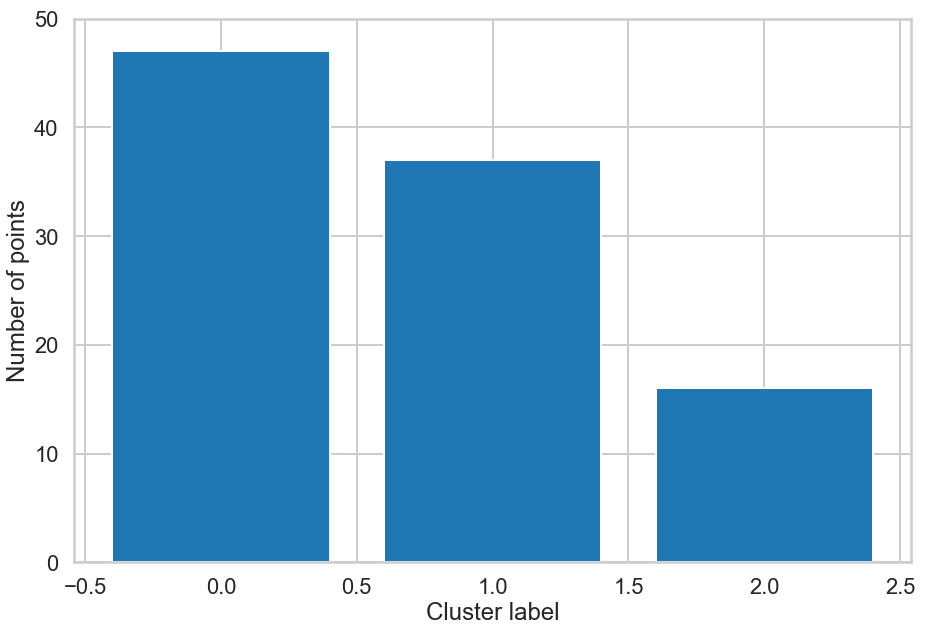

In [18]:
k = 3
model = KMeans(n_clusters=k)

labels = model.fit_predict(x_cols)
x, y = np.unique(labels, return_counts=True)


plt.bar(x, y)
plt.yticks([0,10,20,30,40,50])
plt.xlabel('Cluster label')
plt.ylabel('Number of points')
plt.show()

### What challenges did you experience using the Elbow method to pick 𝐾? 
* The main challenge with using the Elbow method is that there is no clear elbow in the graph. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters= 2 The average silhouette score is : 0.09174871508750351
For n_clusters= 3 The average silhouette score is : 0.11015391298263667
For n_clusters= 4 The average silhouette score is : 0.12564658165166884
For n_clusters= 5 The average silhouette score is : 0.11866478362380166
For n_clusters= 6 The average silhouette score is : 0.1326505289049699
For n_clusters= 7 The average silhouette score is : 0.14695219341248295
For n_clusters= 8 The average silhouette score is : 0.11837724905289926
For n_clusters= 9 The average silhouette score is : 0.12207088372386639
For n_clusters= 10 The average silhouette score is : 0.12224915149092208


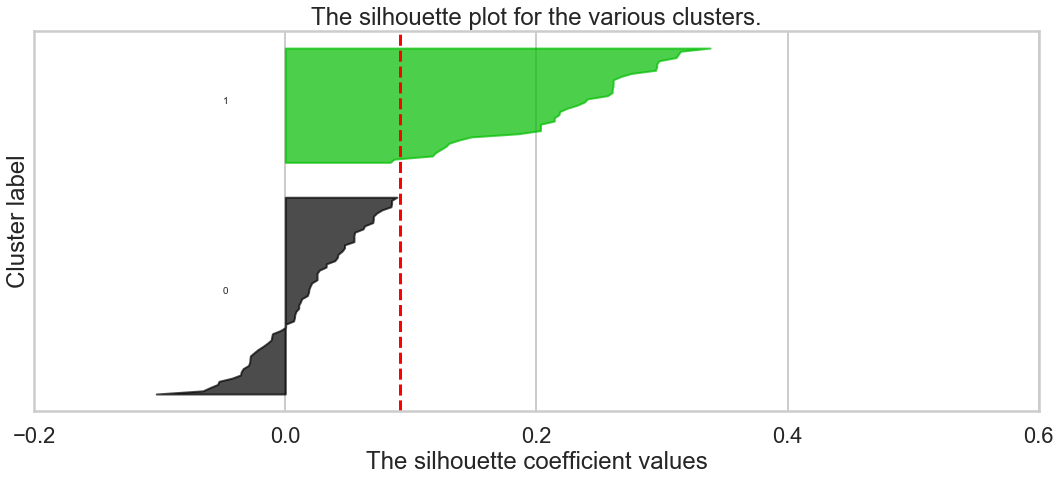

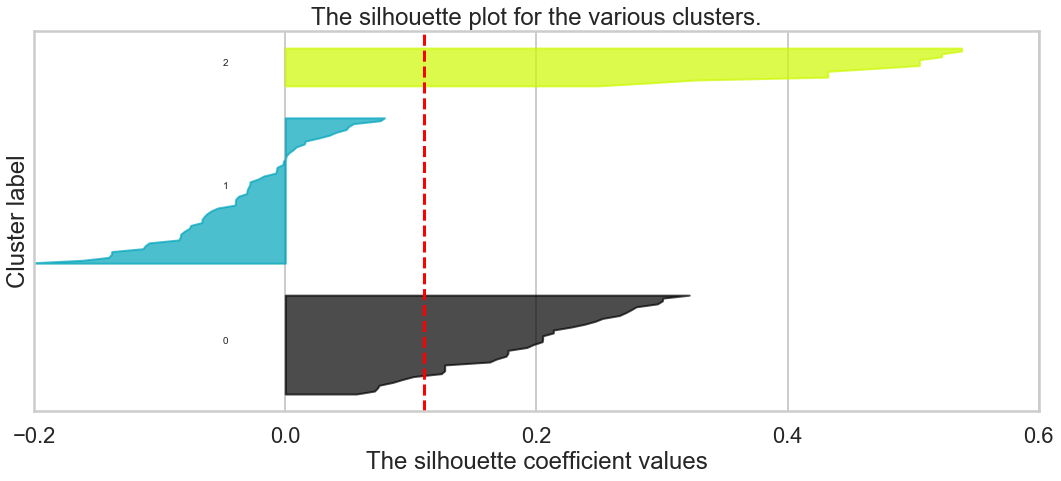

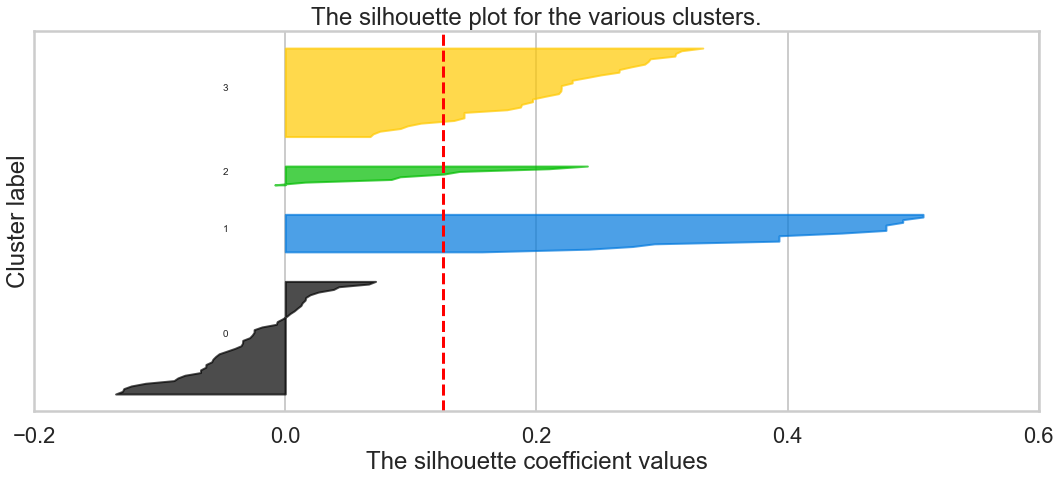

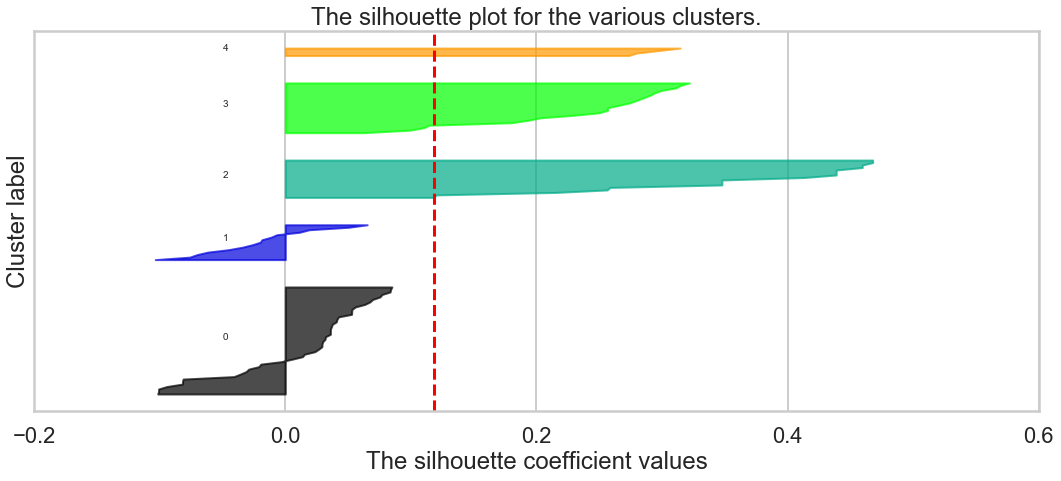

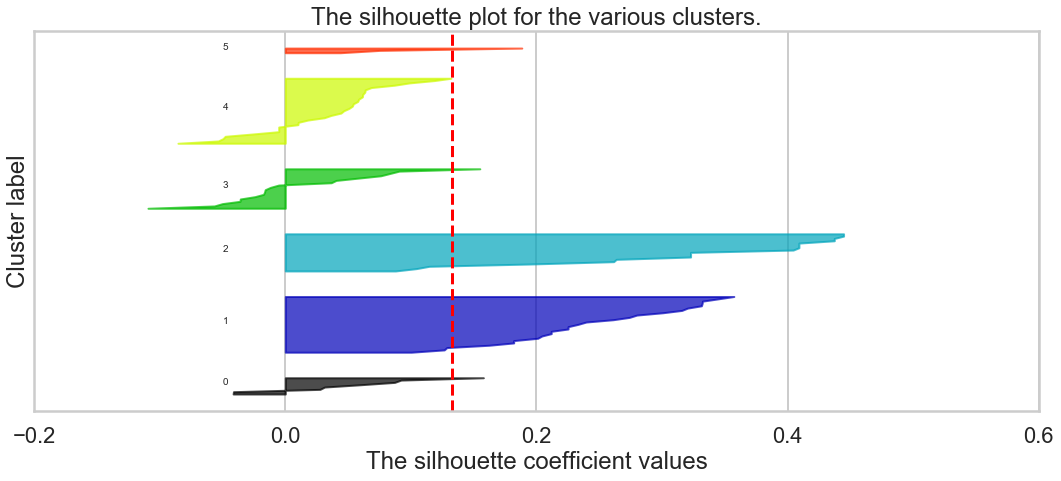

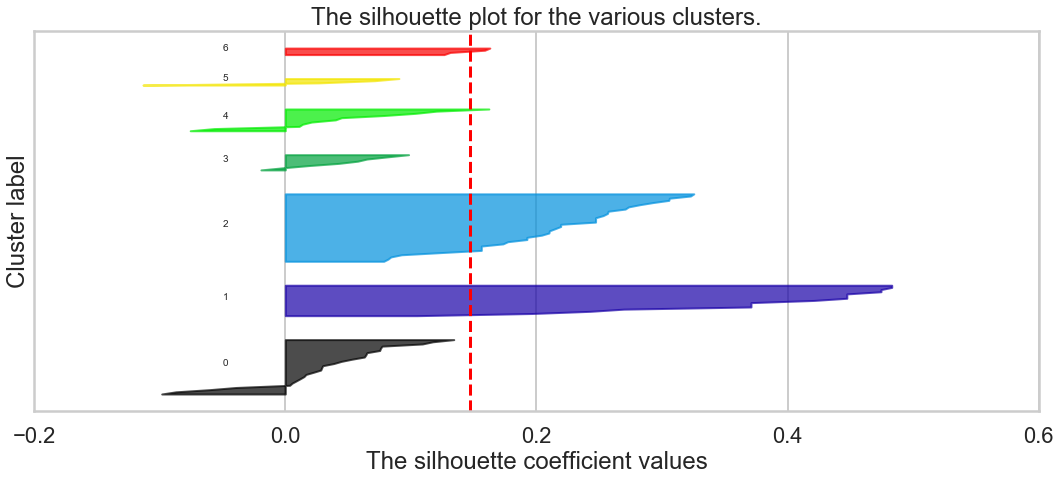

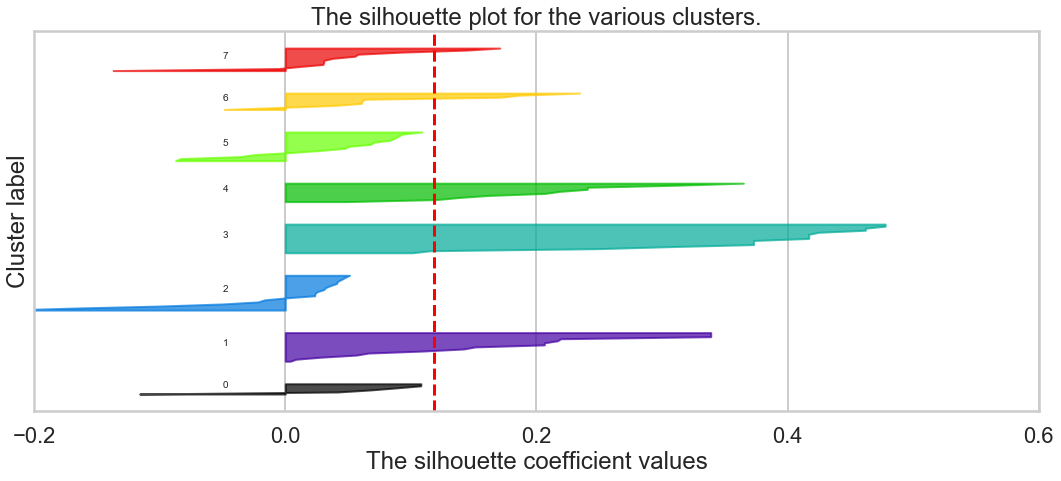

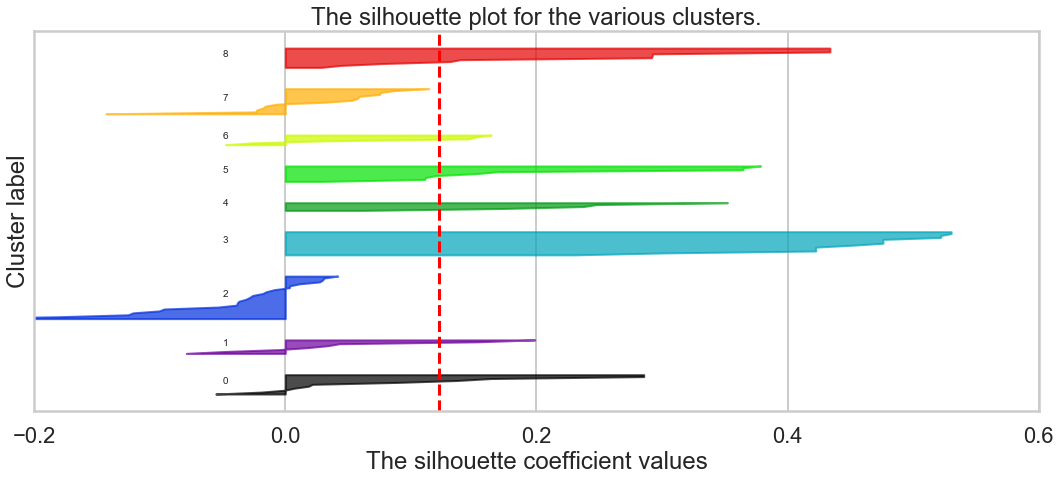

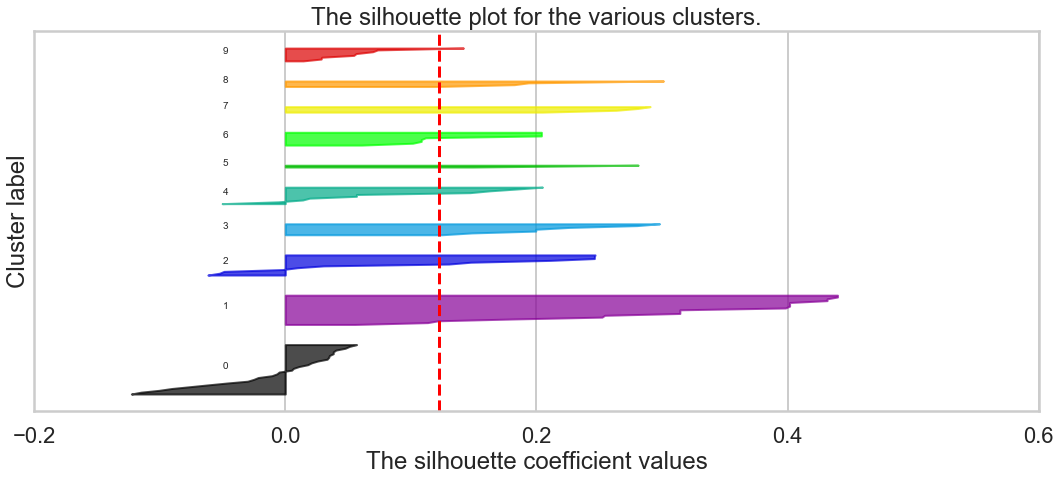

In [19]:
# Your turn.
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

scores = []

for k in ks:
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.6])
    
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(x_cols)
    
    sil_avg = silhouette_score(x_cols, labels)
    print('For n_clusters=', k, 'The average silhouette score is :', sil_avg)
    scores.append(sil_avg)
    
    sil_values = silhouette_samples(x_cols, labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sil_values[labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax1.axvline(x=sil_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])
    
plt.show()

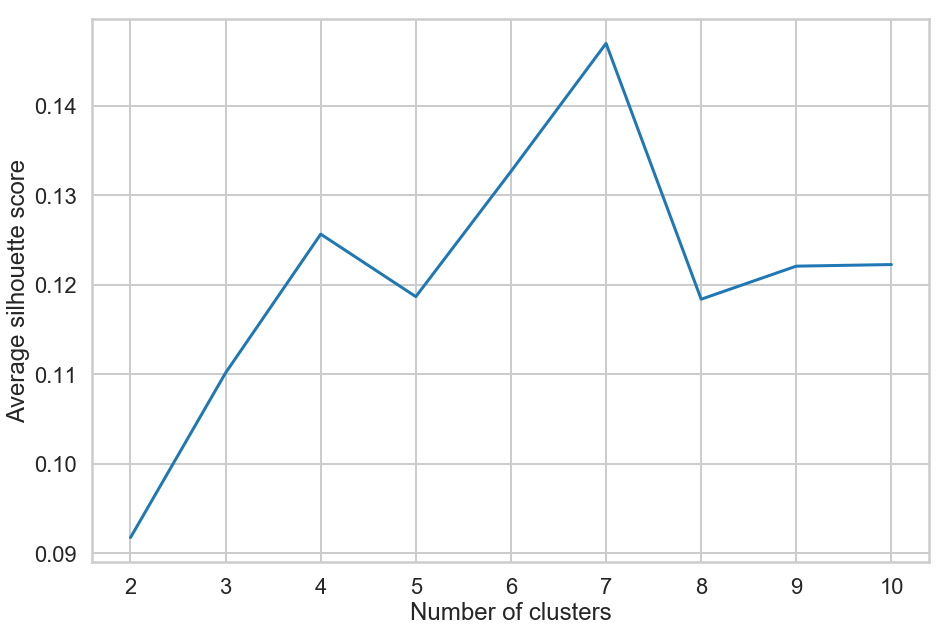

In [33]:
plt.plot(ks, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.show()

### What 𝐾 does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
* The plot suggests that 8 would be a good value for K. However, as mentioned earlier, it would likely be difficult to get any kind of meaning out of the 8 clusters in this use case. There is a local maximum at K=4, so perhaps this is a good value to choose. Yes, this is different than the K=3 value that I selected from the Elbow method, but only different by 1.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

  customer_name  cluster_id         x         y
0         Adams           0  1.007580  0.108215
1         Allen           2 -0.287539  0.044715
2      Anderson           1 -0.392032  1.038391
3        Bailey           0  0.699477 -0.022542
4         Baker           2  0.088183 -0.471695


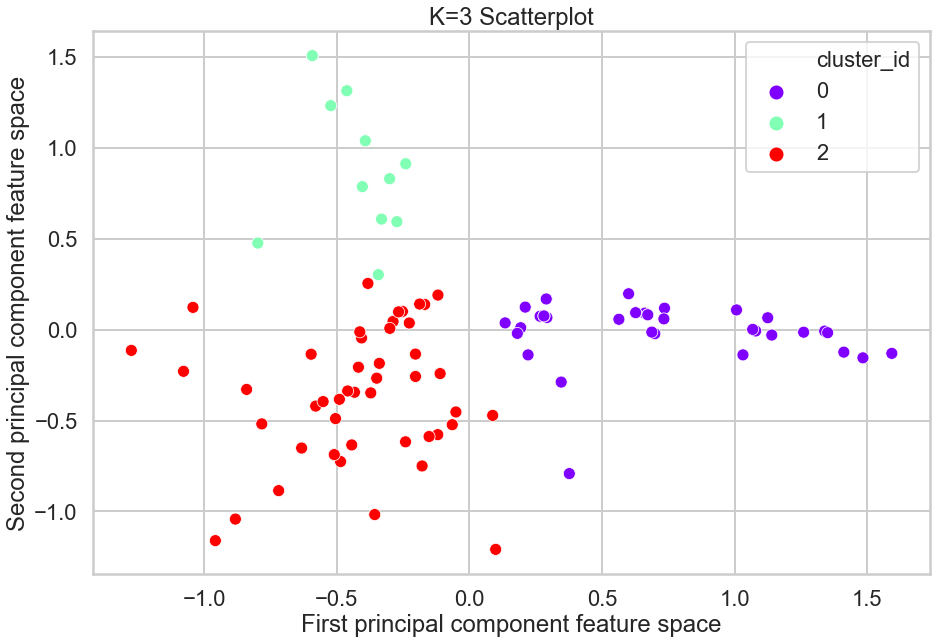

In [34]:
#your turn
from sklearn.decomposition import PCA
model = KMeans(n_clusters=3, random_state=1)
labels = model.fit_predict(x_cols)
pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': labels, 'x':x, 'y':y})
print(pca_df.head())

sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('K=3 Scatterplot')
plt.show()

### How do the clusters look? 
* The clusters look fairly well defined. You can clearly distinguish the 3 clusters, and given a new datapoint you would likely have a good idea as to what cluster do they belong.

### Based on what you see, what seems to be the best value for 𝐾? 
* I was choosing between K=3 and K=4. The plot above shows K=3, so let's do the same for K=4 to see if it is any better.

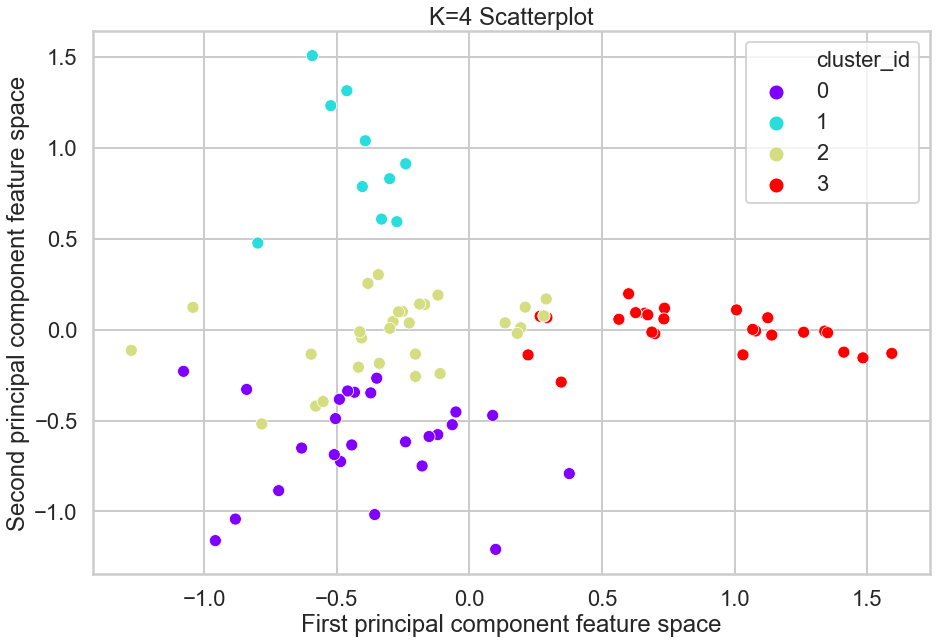

In [35]:
model = KMeans(n_clusters=4, random_state=1)
labels = model.fit_predict(x_cols)


pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': labels, 'x':x, 'y':y})

sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('K=4 Scatterplot')
plt.show()

### Moreover, which method of choosing 𝐾 seems to have produced the optimal result visually? 
* The plot above is decently defined, but shows some overlap between clusters 0, 2, and 3.
* Based on these to plots, K=3 seems to better represent the data, so using the Elbow method produced the optimal result visually.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

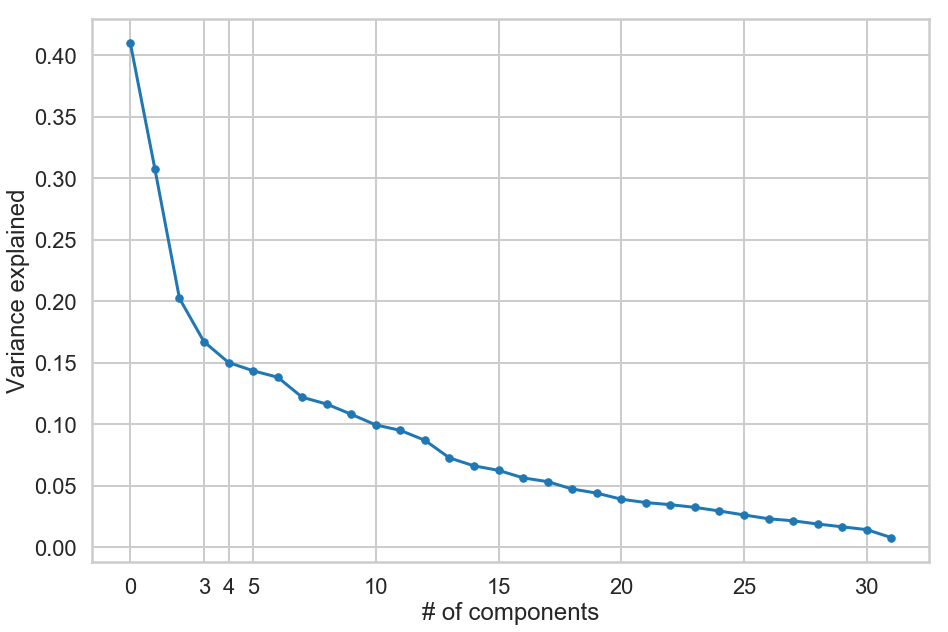

In [36]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
variance = pca.explained_variance_

plt.plot(range(len(variance)), variance, marker='.', markersize=15)
plt.xlabel('# of components')
plt.ylabel('Variance explained')
plt.xticks([0,3,4,5,10,15,20,25,30])
plt.show()

### Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?
* Based on the plot above, it looks like the inherent dimensionality of the data is either 3 or 4. This matches what I found using the Elbow method and the silhouette score.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [24]:
# Your turn
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Affinity Propagation

For parameter = 0.5 The average silhouette score is : 0.12346523604478911
For parameter = 0.6 The average silhouette score is : 0.12346523604478911
For parameter = 0.7 The average silhouette score is : 0.12346523604478911
For parameter = 0.7999999999999999 The average silhouette score is : 0.08954554999885996
For parameter = 0.8999999999999999 The average silhouette score is : 0.08954554999885996
Best parameter = 0.5
Best silhouette average =  0.12346523604478911
Estimated number of clusters: 14


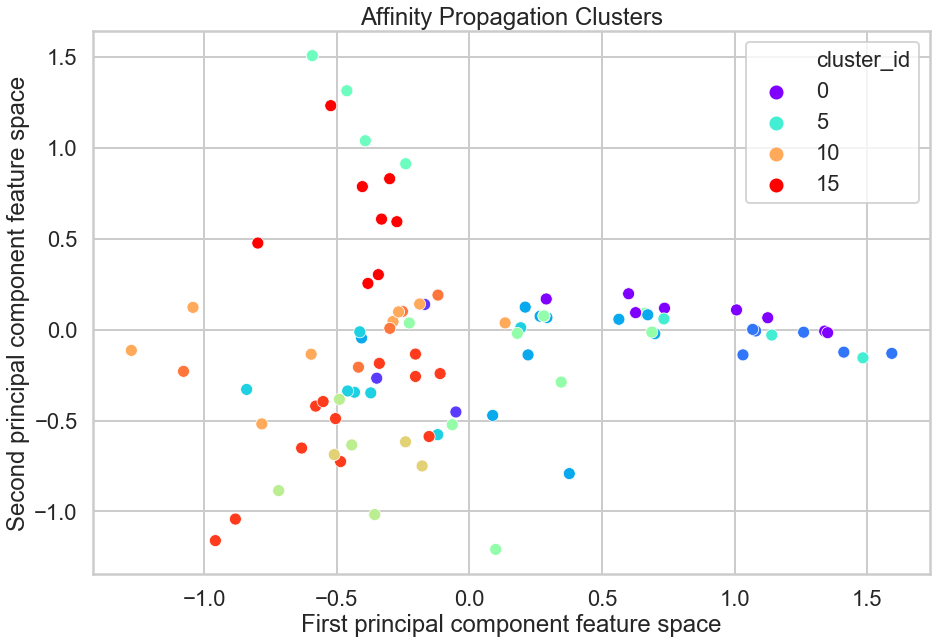

In [100]:
AP_model = AffinityPropagation()
AP_labels = AP_model.fit_predict(x_cols)
cluster_centers_indices = AP_model.cluster_centers_indices_

scores = []

param_range = np.arange(0.5, 1, 0.1)

for param in param_range:
    
    model = AffinityPropagation(damping=param)
    labels = model.fit_predict(x_cols)
    
    sil_avg = silhouette_score(x_cols, labels)
    print('For parameter =', param, 'The average silhouette score is :', sil_avg)
    scores.append(sil_avg)
    
best_param = param_range[scores.index(max(scores))]
print('Best parameter =', best_param)
print('Best silhouette average = ', max(scores))

AP_model = AffinityPropagation(damping=best_param)
AP_labels = AP_model.fit_predict(x_cols)
cluster_centers_indices = AP_model.cluster_centers_indices_

print('Estimated number of clusters: {}'.format(len(cluster_centers_indices)))

pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_cols)
x = pca_features[:,0]
y = pca_features[:,1]
pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': AP_labels, 'x':x, 'y':y})

sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('Affinity Propagation Clusters')
plt.show()

# Spectral Clustering

For parameter = 0.01 The average silhouette score is : 0.1339254037001241
For parameter = 0.1 The average silhouette score is : 0.11404085406952898
For parameter = 1 The average silhouette score is : 0.1064339025759081
For parameter = 10 The average silhouette score is : 0.0545757760827264
For parameter = 100 The average silhouette score is : 0.16468837239678863
For parameter =

C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


 1000 The average silhouette score is : -0.06735093674883881
Best parameter = 100
Best silhouette average =  0.16468837239678863


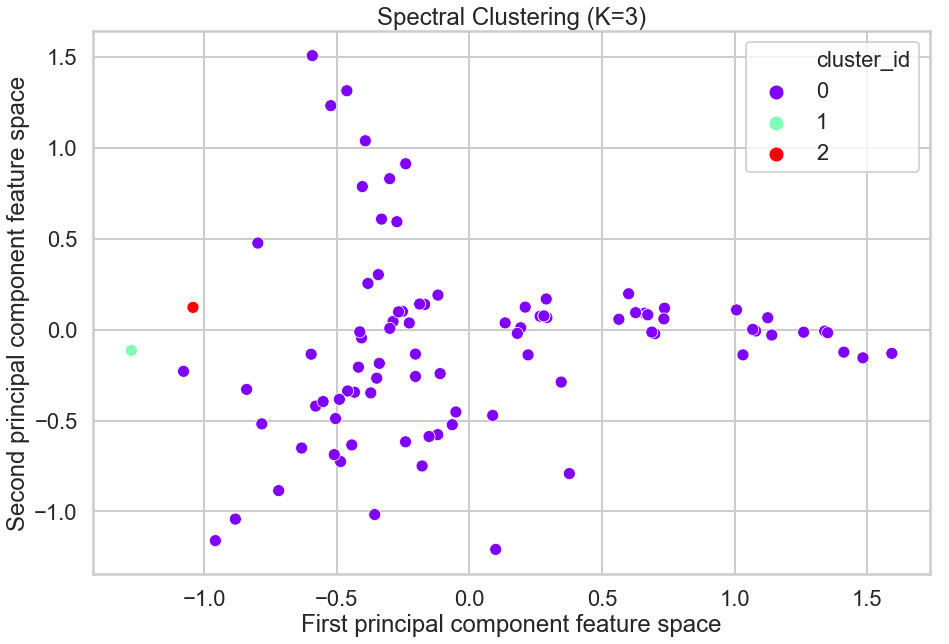

In [110]:

param_range = [0.01, 0.1, 1, 10, 100, 1000]
scores = []

for param in param_range:    
    model = SpectralClustering(gamma=param)
    labels = model.fit_predict(x_cols)
    
    sil_avg = silhouette_score(x_cols, labels)
    print('For parameter =', param, 'The average silhouette score is :', sil_avg)
    scores.append(sil_avg)
    
best_param = param_range[scores.index(max(scores))]
print('Best parameter =', best_param)
print('Best silhouette average = ', max(scores))

SC_model = SpectralClustering(n_clusters=3, random_state=42, gamma=best_param)

SC_labels = SC_model.fit_predict(x_cols)

pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': SC_labels, 'x':x, 'y':y})


sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('Spectral Clustering (K=3)')
plt.show()

### In this case, tuning the hyperparameter gamma to maximize the silhouette score gives an unusual result where most of the points are in cluster 0, while clusters 1 and 2 have only one point each. Leaving gamma at it's default value produces a result similar to K Means:

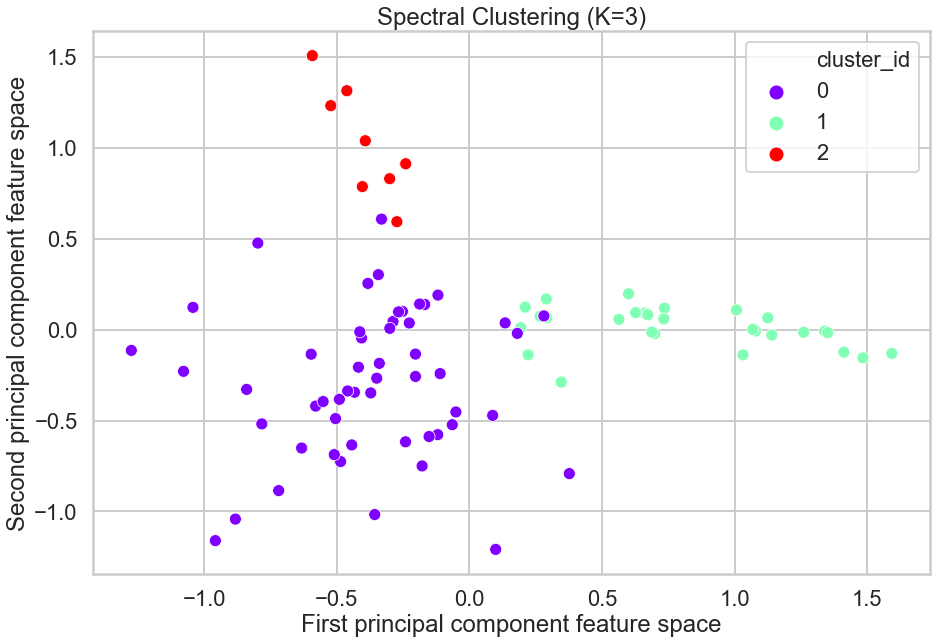

In [111]:
SC_model = SpectralClustering(n_clusters=3, random_state=42, gamma=1.0)

SC_labels = SC_model.fit_predict(x_cols)

pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': SC_labels, 'x':x, 'y':y})


sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('Spectral Clustering (K=3)')
plt.show()

# Agglomerative Clustering

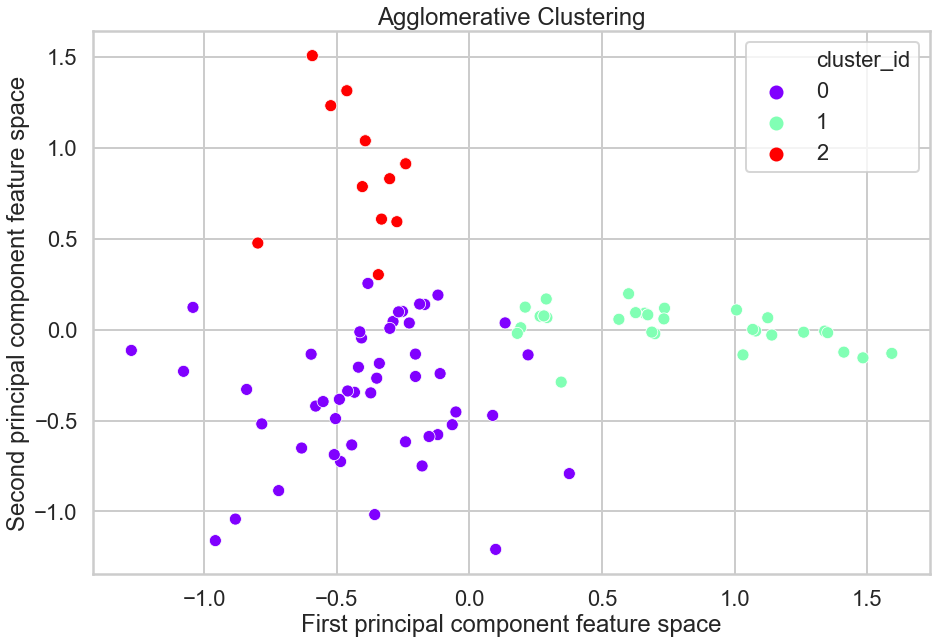

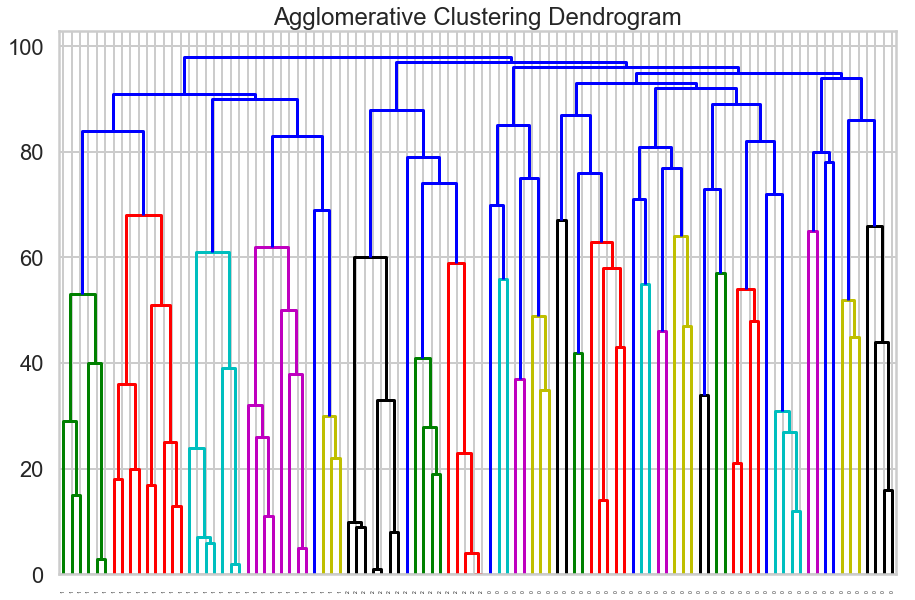

In [51]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


AC_model = AgglomerativeClustering(n_clusters=3)
AC_labels = AC_model.fit_predict(x_cols)



pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': AC_labels, 'x':x, 'y':y})


sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('Agglomerative Clustering')
plt.show()

plot_dendrogram(AC_model, labels=AC_labels)
plt.title('Agglomerative Clustering Dendrogram')
plt.show()

# DBSCAN

For parameter = 1 The average silhouette score is : 0.012715203274911742
For parameter = 1.5 The average silhouette score is : 0.11989886685810866
For parameter = 2.0 The average silhouette score is : 0.2348896595208253
Best parameter = 2.0
Best silhouette average =  0.2348896595208253


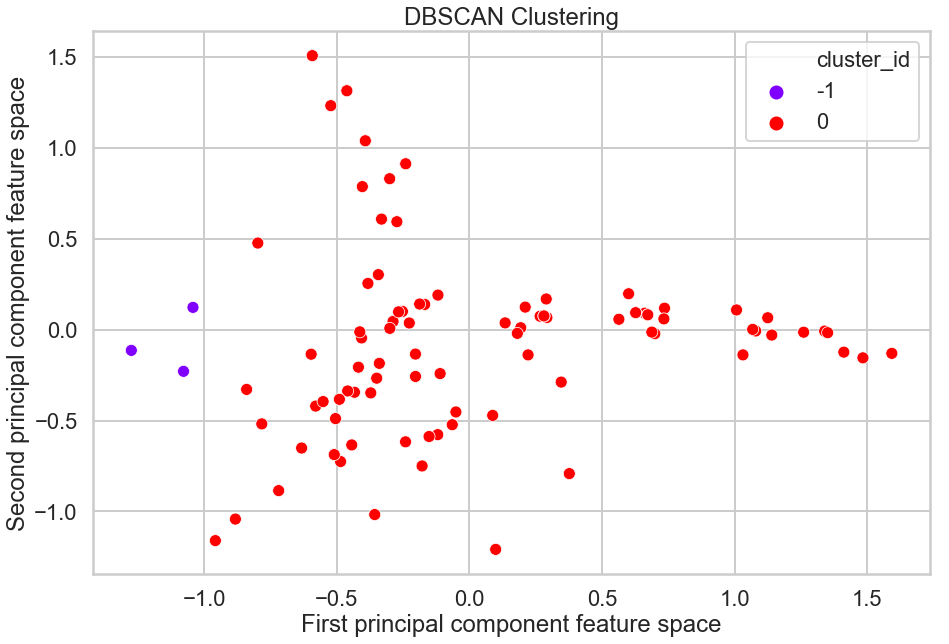

In [119]:
param_range = [1, 1.5, 2.0]
scores = []

for param in param_range:    
    model = DBSCAN(eps=param)
    labels = model.fit_predict(x_cols)
    
    sil_avg = silhouette_score(x_cols, labels)
    print('For parameter =', param, 'The average silhouette score is :', sil_avg)
    scores.append(sil_avg)
    
best_param = param_range[scores.index(max(scores))]
print('Best parameter =', best_param)
print('Best silhouette average = ', max(scores))


DB_model = DBSCAN(eps=best_param)
DB_labels = DB_model.fit_predict(x_cols)

pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_cols)

x = pca_features[:,0]
y = pca_features[:,1]

pca_df = pd.DataFrame({'customer_name': pivot.index, 'cluster_id': DB_labels, 'x':x, 'y':y})


sns.scatterplot(pca_df.x, pca_df.y, hue=pca_df.cluster_id, palette='rainbow')
plt.xlabel('First principal component feature space')
plt.ylabel('Second principal component feature space')
plt.title('DBSCAN Clustering')
plt.show()

### With DBSCAN when the data are too noisy to be assigned to a cluster they are given a cluster id of -1. For most values of `eps` (the maximum distance between two samples to be considered in the same neighborhood) the entire sample is assigned cluster id of -1 and thus no silhouette score can be calculated. Testing over `eps` values that actually give silhouette scores shows 2 to be the best value. The results look similar to those of Spectral Clustering when gamma was tuned. 

# How do their results compare? Which performs the best? Tell a story why you think it performs the best.
* Affinity Clustering finds 14 clusters on only 100 data points. Plotting the PCA components shows a hodgepodge of cluster ids that overlap and give no useful information.

* Spectral Clustering requires you to choose the number of clusters a priori, so I chose 3. The results look very similar to the results of K Means on this dataset.

* Agglomerative Clustering can take an a priori number of clusters as a parameter, or a distance treshold beyond which two clusters will not be joined. The latter option will estimate the number of clusters when no two clusters are closer than the distance threshold. This may be a good way to estimate the number of thresholds, but without any information suggesting what a good threshold would be I chose to have it find 3 clusters. One nice feature of hierarchical and agglomerative clustering is that you can produce a dendrogram to visualize the iterative process of finding clusters. When finding 3 clusters, agglomerative clustering produced results very similar to K means and spectral clustering.

* With DBSCAN all of the datapoints are assigned to the same cluster, or else the data are too noisy to be assigned at all. 

## Summary:
### With only 100 data points, it is unlikely that any unsupervised clustering will yield very good results, regardless of the clustering algorithm. DBSCAN and Spectral Clustering might be the most truthful in that they indicate that the data do not allow for very effective clustering. There just aren't destinct classes to assign each datapoint to. However, the clusters produced by KMeans, and Agglomerative Clustering are very similar and may be useful if the clusters can be interpretted in a way that yields actionable results (i.e. targetting certain offers to specific classes of customers).